**Training ML Models**

Gather data and make train/test sets. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Fix random state for reproducibility
randomState = 100

In [2]:
data = pd.read_csv(r"..\processed_data\Mexico_Indigenous_Covid_Data.csv")

In [3]:
from sklearn.model_selection import train_test_split, cross_validate
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = randomState, stratify = y)

In [4]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve 
# convert predicted probabilites into labels
# given threashold
def thresh_to_label(y, thresh):
        return 1 if y >= thresh else 0

#Function to plot our statistics
def print_model_stats(model, X_test, y_test, threshold = .5, thresh_print ="n"):
    y_pred = model.predict_proba(X_test)[:,1] 
    
    if thresh_print == "y":
        _, _, thresholds = precision_recall_curve(y_test, y_pred)
        print(f"Thresholds are \n{thresholds}")
    
    y_pred = [thresh_to_label(y, threshold) for y in y_pred] 
    
    accuracy = metrics.accuracy_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred)

    cm = metrics.confusion_matrix(y_test,y_pred)

    tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()

    print(f"\nConfusion Matrix is \n {cm}")
    print(f"True Negatives = {tn}")
    print(f"False Positives = {fp}")
    print(f"False Negatives = {fn}")
    print(f"True Positives = {tp}")
    
    print(f"Precision is {precision: .3f}")
    print(f"Recall is {recall: .3f}")
    print(f"Accuracy is {accuracy: .3f}")



In [5]:
from functools import reduce

# function to plot scores from cross validation
def cv_scores(model,X,y, cv = 10):
    model_scores = ["accuracy","precision", "recall"]
    scores = cross_validate(model, X,y, cv = cv, scoring = model_scores, 
                            return_train_score = True)

    ac = reduce(lambda x,y: x+y ,scores["test_accuracy"])/len(scores["test_accuracy"])
    pr = reduce(lambda x,y: x+y ,scores["test_precision"])/len(scores["test_precision"])
    re = reduce(lambda x,y: x+y ,scores["test_recall"])/len(scores["test_recall"])
    
    print(f"Average Precision is {pr: .3f}")
    print(f"Average Recall is {re: .3f}")  
    print(f"Average Accuracy is {ac :.3f}")                          


In [6]:
from sklearn.metrics import average_precision_score

def plot_pr_curve(model, X_test, y_test, label = "Model Name", plot = "y", 
                  naive= "y", p_score = "y"):
    
    aps = average_precision_score 
    y_scores = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    # plot no skill/ random classifying
    if naive == "y":
        naive_pred = len(y_test[y_test==1])/len(y_test)
        plt.plot([0,1],[naive_pred,naive_pred], linestyle = "--", label = "Naive_prediction")

    plt.xlabel("Recall", fontsize=14 ) 
    plt.ylabel("Precision", fontsize=14)
    if p_score == "y":
        print(label + f" Average Precision Score: {aps(y_test, y_scores):.3f}\n")
        plt.title( label + "\n" +f"Precision-Recall Curve",fontsize=18)
    else: 
        plt.title(f"Precision-Recall Curves", fontsize=18)
    plt.plot(recall, precision, label = label)
    leg = plt.legend(loc='best', ncol=1, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.75)
    
    if plot == "y":
        plt.show()


In [7]:
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, 
                                              random_state = randomState, class_weight="balanced")
tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [8]:
print("Evaluating Decision Tree")
print_model_stats(tree_classifier, X_test, y_test, threshold = 0.62)

Evaluating Decision Tree

Confusion Matrix is 
 [[2070  704]
 [  10   75]]
True Negatives = 2070
False Positives = 704
False Negatives = 10
True Positives = 75
Precision is  0.096
Recall is  0.882
Accuracy is  0.750


Decision Tree Average Precision Score: 0.089



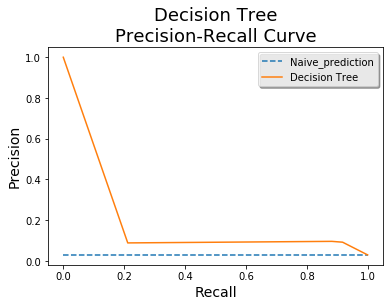

In [9]:
plot_pr_curve(tree_classifier, X_test, y_test, label = "Decision Tree")

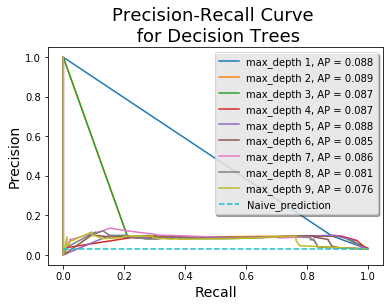

In [10]:
#plot various decision trees
for i in range(1,10):
    tree_class = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = i, random_state = randomState, class_weight='balanced')
    tree_class.fit(X_train,y_train)
    
    y_scores = tree_class.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    aps = average_precision_score
    plt.plot(recall, precision, label = f"max_depth {i}, AP = {aps(y_test, y_scores) :.3f}")
    
    # plot no skill classifying i.e. average number of ones
    naive_pred = len(y_test[y_test==1])/len(y_test)
    
plt.plot([0,1],[naive_pred,naive_pred], linestyle = "--", label = "Naive_prediction")
plt.xlabel("Recall", fontsize=14 ) 
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve \n for Decision Trees", fontsize=18,)

leg = plt.legend(loc='best', ncol=1, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.75)
plt.show()


In [11]:
from sklearn.ensemble import RandomForestClassifier
rand_forest_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 2, 
                                                random_state=randomState, criterion = "entropy", 
                                                class_weight='balanced')
rand_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

In [12]:
print("Evaluating Random Forest")
print_model_stats(rand_forest_classifier, X_test, y_test, threshold = 0.62)

Evaluating Random Forest

Confusion Matrix is 
 [[2258  516]
 [  23   62]]
True Negatives = 2258
False Positives = 516
False Negatives = 23
True Positives = 62
Precision is  0.107
Recall is  0.729
Accuracy is  0.811


Random Forest Average Precision Score: 0.095



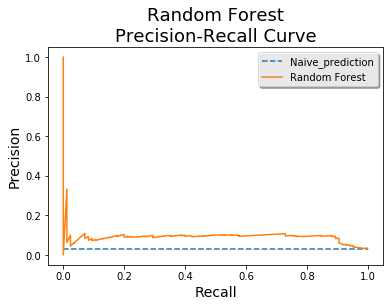

In [13]:
plot_pr_curve(rand_forest_classifier, X_test, y_test, label = "Random Forest")

In [14]:
from sklearn.linear_model import LogisticRegression

log_classifier = LogisticRegression(random_state=randomState, 
                                    solver = "newton-cg", class_weight='balanced')
log_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=100, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
print("Evaluating Logistic Regression")
print_model_stats(log_classifier, X_test, y_test, threshold =0.67)

Evaluating Logistic Regression

Confusion Matrix is 
 [[2087  687]
 [  11   74]]
True Negatives = 2087
False Positives = 687
False Negatives = 11
True Positives = 74
Precision is  0.097
Recall is  0.871
Accuracy is  0.756


Logistic Regression Average Precision Score: 0.083



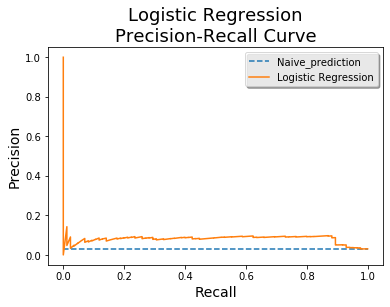

In [16]:
plot_pr_curve(log_classifier, X_test, y_test, label = "Logistic Regression")

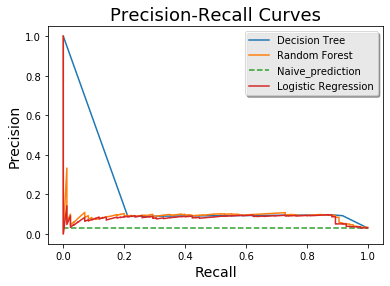

In [17]:
plot_pr_curve(tree_classifier, X_test, y_test, 
              label = "Decision Tree", plot = "n", naive= "n",  p_score = "n")
plot_pr_curve(rand_forest_classifier, X_test, y_test, 
              label = "Random Forest", plot = "n", naive= "n", p_score = "n")
plot_pr_curve(log_classifier, X_test, y_test, 
              label = "Logistic Regression", p_score = "n")

In [18]:
cv_scores(tree_classifier, X,y, cv = 10)

Average Precision is  0.097
Average Recall is  0.867
Average Accuracy is 0.749


In [19]:
cv_scores(rand_forest_classifier, X,y, cv = 10)

Average Precision is  0.101
Average Recall is  0.867
Average Accuracy is 0.761


In [20]:
cv_scores(log_classifier, X,y, cv = 10)

Average Precision is  0.101
Average Recall is  0.867
Average Accuracy is 0.760
